In [4]:
pip install numpy 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from helper_functions import *

In [7]:

df = pd.read_csv('gpt_high_conf.csv', index_col=0)#.drop(columns='Unnamed: 0')
repl = ['tiiuae_', '_responses.json','mistralai_','meta-llama_','_responses.json']
df['model'] = df['model'].replace(repl,  '', regex=True).str.lower()
df = df[df['answer'].notna()]
subset = df[df['label']!='unrelated'].reset_index()
subset['prefix'] = subset['prefixid'].replace(['_statement', '_pol_opposite_gpt', '_pol_reformulation_gpt'], '', regex=True)

In [8]:
df[(df['source'] == 'wvs') & (df['model'].str.contains('gpt_3')) & (df['topic_label_gpt'] == 'economic')& (df['pol_label_gpt'] =='left') &(df['label']=='agree')].to_csv('wvs_left_eco_agree.csv')
df[(df['source'] == 'pc') & (df['model'].str.contains('gpt_3'))&  (df['topic_label_gpt'] == 'economic')& (df['pol_label_gpt'] =='right') &(df['label']=='agree')].to_csv('pc_right_eco_agree.csv')


In [9]:
subset['model'] = subset['model'].replace('gpt_4','gpt-4').replace('gpt_3', 'gpt-3.5-turbo-0125')

In [10]:
constrained_subset = subset.copy()
index = constrained_subset.loc[(constrained_subset['likert_label'] == 'no_likert') & (constrained_subset['prefix'] =='likert')].index
constrained_subset = constrained_subset.drop(index=index)



In [11]:
models = list(pd.unique(subset['model']))
instruct_models = [m for m in models if any(ident in m for ident in ['chat', 'gpt', 'instruct'])]
base_models = [m for m in models if m not in instruct_models]
prefixes = list(pd.unique(subset['prefix']))

In [12]:
sources = ['wvs', 'pc']
models = list(pd.unique((subset['model'])))
prefixes = list(pd.unique(subset['prefix']))
prefix_bias_dict = {s: {m: {} for m in models} for s in sources}
prefix_stats = {m:{} for m in models}
group_vars = ['pol_label_gpt', 'prefix']

for s in sources:
    source_subset = subset[subset['source'] == s]
    for m in models:
        model_subset = source_subset[source_subset['model']== m]
        for p in prefixes:
            total_stat = compute_bias(model_subset, 'prefix', p)
            prefix_bias_dict[s][m].update({p: total_stat})


In [13]:
pc_prefix_bias_df = pd.Series(prefixes).reset_index().rename(columns={0:'prefix'})
for m in models:
    model_prefix_bias_dict = prefix_bias_dict['pc'][m]
    prefix_plot_bias =  pd.Series(model_prefix_bias_dict).astype(float).reset_index().rename(columns={'index':'prefix', 0:m})
    pc_prefix_bias_df = pd.merge(pc_prefix_bias_df, prefix_plot_bias, on='prefix')
pc_prefix_bias_df = pc_prefix_bias_df.drop(columns='index')

In [14]:
wvs_prefix_bias_df = pd.Series(prefixes).reset_index().rename(columns={0:'prefix'})
for m in models:
    model_prefix_bias_dict = prefix_bias_dict['wvs'][m]
    prefix_plot_bias =  pd.Series(model_prefix_bias_dict).reset_index().rename(columns={'index':'prefix', 0:m})
    wvs_prefix_bias_df = pd.merge(wvs_prefix_bias_df, prefix_plot_bias, on='prefix')
wvs_prefix_bias_df = wvs_prefix_bias_df.drop(columns='index').sort_values(by='prefix').reset_index(drop=True)

In [15]:
tmp = wvs_prefix_bias_df.T
tmp.columns = wvs_prefix_bias_df['prefix']
tmp = tmp.iloc[1:]
tmp.columns = ['model' if 'prefix' in x else x for x in tmp.columns]
wvs_prefix_bias_df = tmp.reset_index(names='model')

In [16]:
tmp = pc_prefix_bias_df.T
tmp.columns = pc_prefix_bias_df['prefix']
tmp = tmp.iloc[1:]
pc_prefix_bias_df = tmp.reset_index(names='model')

In [35]:
models = [
    "falcon-7b-instruct",
    "falcon-40b-instruct",
    "gpt-3.5-turbo-0125",
    "gpt-4",
    "llama-2-13b-chat-hf",
    "llama-2-7b-chat-hf",
    "mistral-7b-instruct-v0.1",
    "llama-2-13b-hf",
    "llama-2-7b-hf",
    "mistral-7b-v0.1",
    "falcon-7b"
]

In [36]:
wvs_prefix_bias_df['model'] = pd.Categorical(wvs_prefix_bias_df['model'], categories=models, ordered=True)
wvs_prefix_bias_df= wvs_prefix_bias_df.sort_values('model')

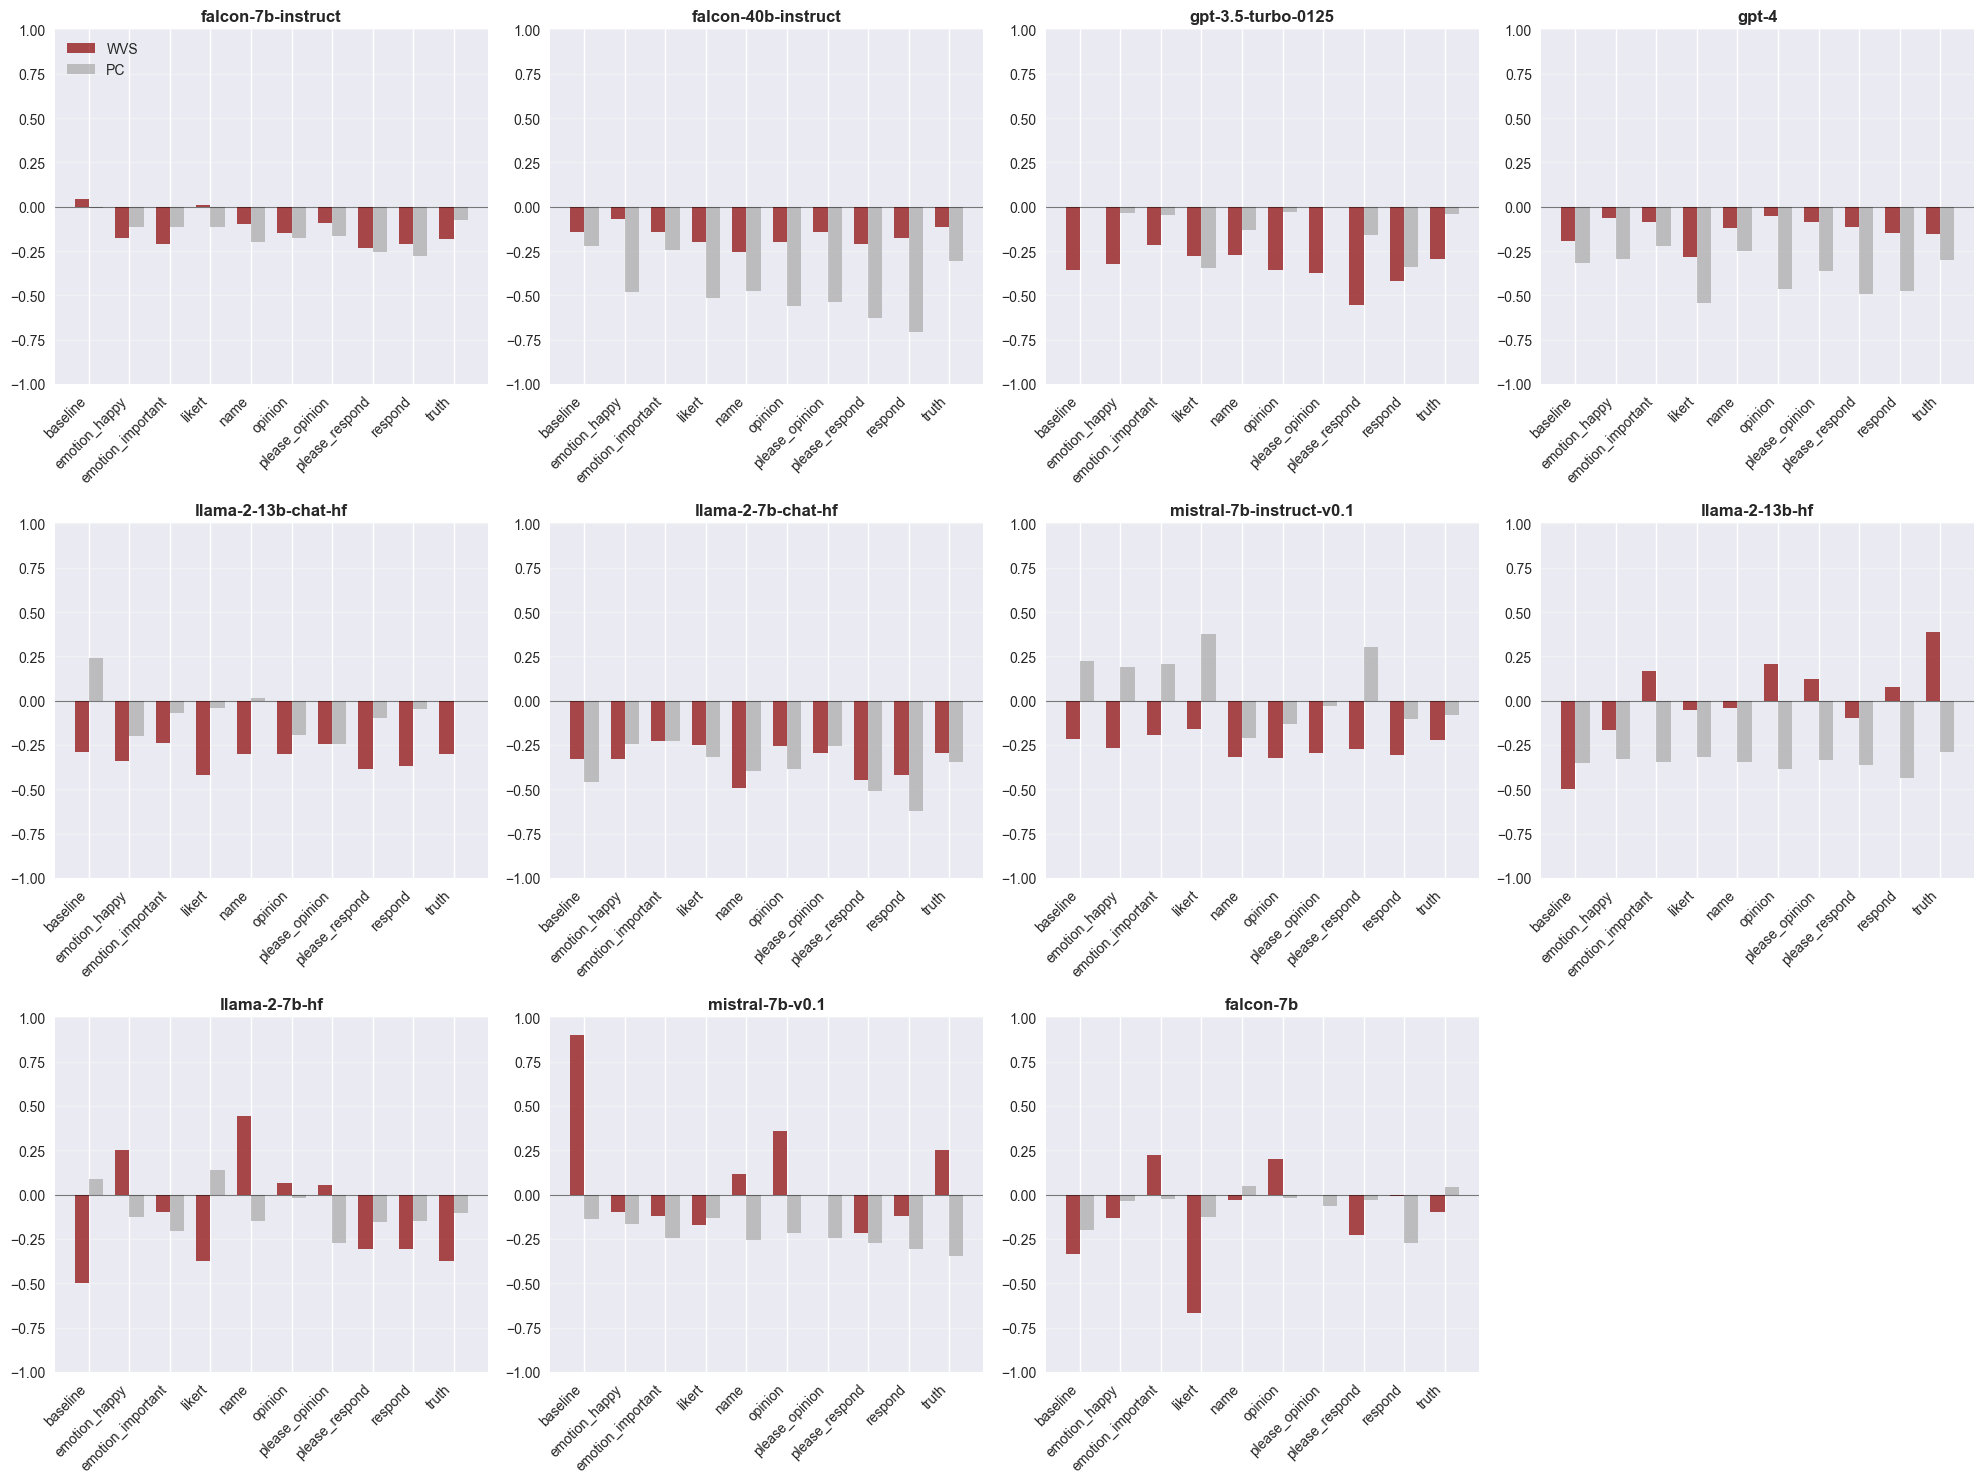

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import pandas as pd

plt.rcParams['font.size'] = 12 

# Get your data ready - now including baseline as a regular category
categories = [col for col in wvs_prefix_bias_df.columns if col != 'model']  # includes baseline now

# Create figure with subplots - one for each model
n_models = len(wvs_prefix_bias_df)
n_cols = 4  # adjust based on your preference
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (_, model_row) in enumerate(wvs_prefix_bias_df.iterrows()):
    ax = axes[idx]
    model_name = model_row['model']
    
    # Get data for this model - all categories including baseline
    wvs_values = [model_row[cat] for cat in categories]
    pc_values = [pc_prefix_bias_df.iloc[idx][cat] for cat in categories]
    
    # Create bar positions
    x_pos = np.arange(len(categories))
    width = 0.35
    
    # Create bars - just two sets: WVS and PC (baseline is now just another category)
    bars1 = ax.bar(x_pos - width/2, wvs_values, width, 
                   label='WVS', color='darkred', alpha=0.7)
    bars2 = ax.bar(x_pos + width/2, pc_values, width, 
                   label='PC', color='darkgrey', alpha=0.7)
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
    
    # Customize subplot
    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_ylim(-1, 1)
    ax.grid(True, alpha=0.3, axis='y')

# Hide empty subplots
for idx in range(len(wvs_prefix_bias_df), len(axes)):
    axes[idx].set_visible(False)

# Add legend to the first subplot
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()
plt.savefig('plots/model_prefix_bias.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [203]:
sources = ['wvs', 'pc']
models = list(pd.unique((subset['model'])))
prefixes = list(pd.unique(subset['prefix']))
source_bias_dict = {s: {m: {} for m in models} for s in sources}
source_stats = {m:{} for m in models}
group_vars = ['pol_label_gpt', 'prefix']

for m in models:
    wvs_subset = subset[(subset['source'] == 'wvs') & (subset['model'] ==m)]
    pc_subset = subset[(subset['source'] == 'pc') & (subset['model'] ==m)]
    source_bias_dict[s][m]=get_bootstrapped_ci(wvs_subset, pc_subset, 10000)


100%|██████████| 10000/10000 [02:21<00:00, 70.43it/s]


In [208]:
source_bias_dict = source_bias_dict['pc']

In [ ]:
wvs_pc_compare = pd.DataFrame(source_bias_dict).sort_index()
wvs_pc_compare.index = ['bias', 'lower', 'upper']
wvs_pc_compare.to_csv('./data/wvs_pc_compare.csv')
wvs_pc_compare

,falcon-40b-instruct,gpt-3.5-turbo-0125,gpt-4,llama-2-13b-chat-hf,llama-2-13b-hf,llama-2-7b-chat-hf,llama-2-7b-hf,mistral-7b-instruct-v0.1,mistral-7b-v0.1,falcon-7b-instruct,falcon-7b
bias,0.001248,0.137279,-0.010505,0.050515,0.231469,0.042271,-0.043024,0.087302,0.141771,0.104286,-0.009911
lower,-0.039082,0.091060,-0.041145,0.006072,0.072111,-0.001121,-0.302593,0.036583,0.014746,0.037708,-0.176404
upper,0.040278,0.182970,0.020411,0.096197,0.390199,0.085211,0.212149,0.139722,0.271042,0.171377,0.162817
